💰 SIMULACIÓN MONTE CARLO PARA ESTRATEGIA APALANCADA (QUANTFURY)
================================================================================

DESCRIPCIÓN GENERAL
-------------------

Este script implementa una simulación Monte Carlo completa para evaluar una 
cartera apalancada en Quantfury. El objetivo es minimizar la probabilidad de 
margin call sin sacrificar el crecimiento compuesto del capital.

El flujo de trabajo se divide en 8 bloques modulares que pueden ejecutarse 
independientemente en un notebook de Colab:

1. Configuración del entorno y metaparámetros
2. Descarga de datos históricos y extracción de ventanas no superpuestas
3. Funciones de optimización (Sharpe Ratio)
4. Optimización de cartera
5. Funciones auxiliares para cálculo de métricas
6. Función principal de simulación Monte Carlo
7. Ejecución de simulaciones (CON DCA y SIN DCA)
8. Comparación y visualización de resultados

JUSTIFICACIÓN DE DECISIONES
----------------------------

📈 Simulación basada en ventanas históricas no superpuestas:
   - En lugar de generar retornos aleatorios con distribución normal, la 
     simulación selecciona ventanas completas de días históricos consecutivos 
     (5-90 días, no superpuestas)
   - Cada ventana se usa completamente antes de seleccionar la siguiente, 
     preservando momentum temporal y autocorrelación
   - Se aplican los retornos REALES de cada día histórico a todos los activos 
     simultáneamente, preservando las correlaciones históricas reales
   - Esto evita valores extremos artificiales que nunca sucedieron en el histórico

📊 Realismo estadístico:
   - Aplicamos un shrink del 80% a las medias históricas para no extrapolar 
     rallies extremos
   - La simulación solo usa días históricos reales, por lo que no puede generar 
     retornos más extremos que los observados en 10 años de datos

🛡️ Gestión del riesgo condicional mejorada:
   - El DCA mensual de 2,000 USD se despliega según un sistema de zonas de 
     seguridad basado en el ratio de margen (equity/exposure)
   - Si el margen está por debajo del 10% (crítico), todo el DCA se mantiene 
     como buffer
   - Entre 10-20% (riesgo), el despliegue se escala linealmente
   - Solo cuando el margen es seguro (≥20%) se considera el despliegue completo, 
     pero incluso entonces se limita al 50% máximo para mantener reservas
   - Esto prioriza la supervivencia sobre el crecimiento inmediato

🔄 Comparación: Gestión ACTIVA vs PASIVA:
   - CON DCA (Activo): Rebalanceo mensual hacia pesos optimizados + despliegue 
     condicional basado en drawdown, volatilidad y desviación de pesos
   - SIN DCA (Pasivo): Sin rebalanceo (pesos derivan naturalmente) + solo mantiene 
     leverage mínimo con contribuciones según pesos actuales
   - Ambas simulaciones usan mismos datos históricos, misma semilla, mismas 
     contribuciones mensuales ($2000) y mismo reborrow dinámico
   - Esto permite cuantificar el valor del rebalanceo activo vs buy & hold

LIMITACIONES PARA MANTENER LA CARTERA REALISTA
-----------------------------------------------

✅ Shrink del 80% sobre las medias históricas antes de optimizar o simular
✅ Peso máximo del 35% por activo en la cartera optimizada y durante el rebalanceo
✅ Peso mínimo del 10% por activo (diversificación forzada)
✅ Apalancamiento fijo de 2.5x (por defecto) o dinámico opcional (reborrow=True):
   - Con reborrow=True: mantiene leverage efectivo mínimo de 2.0x (100% prestado)
   - Cuando el capital crece, el leverage efectivo baja naturalmente (exposure/capital)
   - Si leverage efectivo < 2.0x: pide más prestado para volver a 2.0x (cuando es seguro)
   - Si condiciones muy favorables: permite aumentar hasta 3.5x gradualmente
   - Circuit breaker automático: reduce leverage si margen < 10% (crítico) o 10-20% (riesgo)
✅ Margen de mantenimiento del 5%: la simulación liquida cuando el equity/exposición cruza ese umbral
✅ Aportes mensuales de 2,000 USD con despliegue conservador basado en zonas de seguridad
✅ Horizonte de 5 años con 2,000 escenarios Monte Carlo (configurable)
✅ Calibración con 6 años de datos históricos: extracción de ventanas no superpuestas de 5-90 días
✅ Sin costes de financiación ni spreads (alineado con Quantfury)

RESULTADOS QUE ENTREGAMOS
--------------------------

📊 Métricas de riesgo:
   - Probabilidad de margin call a 1 y 5 años
   - Probabilidad de pérdida (capital final < inversión total)
   - Drawdown máximo por percentil (P10, P50, P90)

💰 Métricas de rentabilidad:
   - Capital final por percentil
   - IRR anualizado basado en flujos de caja reales
   - Sharpe Ratio anualizado por trayectoria

📈 Análisis de realismo:
   - Comparación de volatilidad simulada vs histórica
   - Comparación de frecuencia de días extremos
   - Comparación de drawdowns máximos

🔄 Comparación Gestión ACTIVA vs PASIVA:
   - Tabla comparativa de métricas clave (CON DCA vs SIN DCA)
   - Visualización lado a lado de ambas simulaciones
   - Ambas incluyen contribuciones mensuales y reborrow dinámico

📋 Detalle de despliegue mensual (CON DCA y SIN DCA):
   - Distribución de capital por activo mes a mes (CON DCA: rebalancing activo)
   - Distribución según pesos actuales (SIN DCA: pasivo)
   - Buffer retenido vs capital desplegado
   - Indicadores condicionales que activaron el despliegue

Con estos límites el modelo ofrece una lectura más sobria del potencial de la 
estrategia, cuantifica el valor del colchoncito de margen y facilita comparar 
decisiones de riesgo de forma transparente.

BLOQUE 1: CONFIGURACIÓN DEL ENTORNO Y METAPARÁMETROS
================================================================================

OBJETIVO:
---------
Fijar los supuestos básicos del análisis cargando bibliotecas, definiendo 
constantes del escenario y preparando los pesos iniciales.

DETALLES:
---------
- Se declara la configuración base: 60,000 USD de equity, 2,000 USD de aporte 
  mensual, horizonte de cinco años y 2,000 trayectorias de Monte Carlo
- Se aplica un factor de shrink del 80% a las medias históricas para no 
  extrapolar rallies extremos
- Se limita cada activo al 35% máximo y 10% mínimo
- Se impone un umbral de reapalancamiento en 3x junto a un margen de 
  mantenimiento del 5%
- Se incorporan parámetros para el despliegue condicional del DCA: umbral de 
  drawdown (12%), desviación de pesos (5%), ventana de volatilidad (63 días) y 
  umbral de volatilidad (18% anualizado)

In [1]:
# Block 1: Environment Setup and Meta-Parameters (5 ASSETS & DCA CONFIG)

import yfinance as yf
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime
from scipy.optimize import minimize
from tqdm import tqdm

# ==============================================================================
# 1. MODEL CONFIGURATION (METAPARAMETERS)
# ==============================================================================

# Portfolio setup (Adjusted to 5 assets)
METAPARAMETERS = {
    "initial_capital": 10_000,             # Starting Equity/Collateral in USD
    "monthly_contribution": 1_000,         # New Equity injected every month
    "leverage": 3,                        # Leverage ratio (The core assumption)
    "simulation_years": 5,                 # Projection period for the simulation
    "num_simulations": 10_000,              # Number of Monte Carlo scenarios
    "data_period": 10,                      # Historical period (years)
    "max_weight": 0.35,                   # Constraint: Maximum weight per asset
    "min_weight": 0.15,                   # Constraint: Minimum weight per asset
    "mean_return_shrinkage": 0.8,         # Shrinkage applied to historical means
    "redeploy_leverage_threshold": 3.0,   # Redeploy leverage if drops below this
    "maintenance_margin_ratio": 0.05,     # Margin call triggers at 5% of exposure
    "drawdown_redeploy_threshold": 0.12,  # Drawdown level (12%) for full DCA
    "weight_deviation_threshold": 0.05,   # Max tolerated deviation from target
    "volatility_lookback_days": 63,       # Lookback window for volatility
    "volatility_redeploy_threshold": 0.18, # Annualized volatility threshold
    "safe_margin_ratio": 0.20,            # Safe margin level (20%)
    "critical_margin_ratio": 0.10,         # Critical margin level (10%)
    "gradual_deploy_factor": 0.5,           # Fraction of DCA to deploy gradually
    "train_test_split": 0.7,               # Fraction of windows for optimization
    "reborrow": True,                     # Enable dynamic leverage (reborrow as capital grows)
    "initial_leverage": 2.5,              # Starting leverage ratio (when reborrow=True)
    "min_leverage": 2.5,                   # Minimum leverage target (always maintain when safe)
    "max_leverage": 3.5,                   # Maximum leverage allowed (increases as capital grows)
    "leverage_increase_step": 0.1,         # Leverage increment per month when safe (+0.1x)
    "leverage_increase_margin_ratio": 0.25,  # Min margin ratio to increase leverage (25% = safe)
    "leverage_increase_drawdown_max": -0.05,  # Max drawdown allowed to increase leverage (-5%)
}

# Asset definition and initial weights
PORTFOLIO_INITIAL = {
    "QQQ": 0.22,
    "SPY": 0.22,
    "EZU": 0.20,
    "GLD": 0.16,
    "BTC-USD": 0.20,
}
PORTFOLIO = PORTFOLIO_INITIAL.copy()

# Calculate Total Trading Power and initial weights array
TRADING_POWER = METAPARAMETERS["initial_capital"] * METAPARAMETERS["leverage"]
weights_array = np.array(list(PORTFOLIO.values()))

print("--- 📦 Bloque 1: Configuración cargada (5 activos y DCA) ---")
print(f"Capital Inicial (Equity): ${METAPARAMETERS['initial_capital']:,.0f}")
print(f"Aporte Mensual: ${METAPARAMETERS['monthly_contribution']:,.0f}")
print(f"Apalancamiento: {METAPARAMETERS['leverage']}x")
print(f"Peso Máximo Individual: {METAPARAMETERS['max_weight'] * 100:.0f}%")
print(f"Peso Mínimo Individual: {METAPARAMETERS['min_weight'] * 100:.0f}%")
print(f"Shrink de Retornos Medios: {METAPARAMETERS['mean_return_shrinkage']:.2f}")
print(f"Umbral Drawdown para Redespliegue: {METAPARAMETERS['drawdown_redeploy_threshold'] * 100:.0f}%")
print(f"Umbral Desviación de Pesos: {METAPARAMETERS['weight_deviation_threshold'] * 100:.0f}%")
print(f"Umbral Volatilidad para Redespliegue: {METAPARAMETERS['volatility_redeploy_threshold']:.2f}")

--- 📦 Bloque 1: Configuración cargada (5 activos y DCA) ---
Capital Inicial (Equity): $10,000
Aporte Mensual: $1,000
Apalancamiento: 3x
Peso Máximo Individual: 35%
Peso Mínimo Individual: 15%
Shrink de Retornos Medios: 0.80
Umbral Drawdown para Redespliegue: 12%
Umbral Desviación de Pesos: 5%
Umbral Volatilidad para Redespliegue: 0.18


BLOQUE 2: DESCARGA DE DATOS HISTÓRICOS Y EXTRACCIÓN DE VENTANAS
================================================================================

OBJETIVO:
---------
Obtener precios diarios históricos, extraer ventanas no superpuestas de 
diferentes tamaños (5-90 días) y preparar los datos para la simulación basada 
en patrones históricos reales.

DETALLES:
---------
- Se descargan 6 años de precios ajustados, completando datos de cierre cuando 
  es necesario (especialmente para cripto)
- Se calculan rendimientos logarítmicos diarios y la matriz de covarianza
- Se aplica el factor de shrink del 80% a las medias antes de alimentar el optimizador
- Extracción de ventanas NO SUPERPUESTAS: Se divide el histórico en chunks 
  consecutivos de tamaño aleatorio (5-90 días). Cada día histórico aparece en 
  EXACTAMENTE UNA ventana, eliminando todo sesgo de sobre-muestreo
- División aleatoria de ventanas (train/test): Para evitar sobreajuste a 
  períodos específicos, las ventanas se dividen aleatoriamente (no temporalmente) 
  en train (70%) y test (30%)
  * Train: se usan para optimizar la cartera (calcular covarianza y medias)
  * Test: se usan para la simulación Monte Carlo (datos out-of-sample)
  * Esto asegura que train y test tienen distribuciones estadísticas similares
- Cada ventana almacena los retornos diarios correlacionados reales de todos 
  los activos, preservando las correlaciones históricas observadas
- Se crea la clase TrendSampler que selecciona ventanas completas uniformemente, 
  usando todos los días consecutivos de la ventana antes de pasar a la siguiente

In [2]:
# Block 2: Historical Data Download and Covariance Calculation

def get_historical_data(tickers):
    """Downloads price data, handles MultiIndex, and calculates log returns robustly."""
    print("\n--- 📊 Bloque 2: Procesamiento de datos ---")
    print("Descargando datos históricos...")
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=365 * METAPARAMETERS['data_period'] + METAPARAMETERS['data_period'])

    data = yf.download(list(tickers.keys()), start=start_date, end=end_date, progress=False)

    prices = pd.DataFrame()
    if 'Adj Close' in data.columns.get_level_values(0):
        prices = data['Adj Close'].copy()
    if 'Close' in data.columns.get_level_values(0):
        close_prices = data['Close']
        if prices.empty:
            prices = close_prices.copy()
        else:
            prices.fillna(close_prices, inplace=True)

    if prices.empty:
        raise ValueError("ERROR FATAL: Todos los datos de activos fallaron en descargarse. Verifica tickers o conexión.")

    prices = prices.dropna(axis=1, how='all')
    log_returns = np.log(prices / prices.shift(1)).dropna()
    print("Datos descargados y retornos calculados.")
    return log_returns


def extract_historical_trends(log_returns, min_window=5, max_window=90, step=5):
    """
    Extract NON-OVERLAPPING windows from historical data.
    
    Creates chunks where each day appears in EXACTLY ONE window.
    This eliminates all over-sampling bias while preserving temporal continuity.
    """
    all_windows = []

    num_days = len(log_returns)
    asset_names_list = log_returns.columns.tolist()

    # Create non-overlapping windows with random sizes
    current_idx = 0
    np.random.seed(42)  # For reproducibility

    while current_idx < num_days:
        # Random window size between min and max
        remaining_days = num_days - current_idx
        max_possible = min(max_window, remaining_days)

        if max_possible < min_window:
            # If less than min_window days remain, add them to previous window or skip
            if all_windows:
                # Extend last window
                last_window = all_windows[-1]
                extended_returns = log_returns.iloc[last_window['start_idx']:num_days].values
                last_window['returns'] = extended_returns
                last_window['length'] = len(extended_returns)
            break

        # Random size for this window
        window_size = np.random.randint(min_window, max_possible + 1)
        end_idx = current_idx + window_size

        # Get returns for this window
        window_returns = log_returns.iloc[current_idx:end_idx].values

        all_windows.append({
            'start_idx': current_idx,
            'length': window_size,
            'returns': window_returns.copy()
        })

        current_idx = end_idx

    return all_windows, asset_names_list


# Execute data download
log_returns_full = get_historical_data(PORTFOLIO)

# Estimate trading days per year
yearly_trading_days = 252

print("\n📊 Estrategia de división: Split ALEATORIO por ventanas (sin clasificación)")
print(f"   Total días históricos: {len(log_returns_full)}")
print("\n   🎯 JUSTIFICACIÓN DEL SPLIT ALEATORIO:")
print("   ------------------------------------")
print("   ❌ Split TEMPORAL (2015-2022 / 2022-2023):")
print("      - Las condiciones del mercado pueden ser completamente distintas entre períodos")
print("      - Puede penalizar injustamente estrategias válidas por cambios estructurales")
print("\n   ✅ Split ALEATORIO por ventanas:")
print("      - Mezcla tendencias de TODAS las épocas tanto en train como en test")
print("      - Train y test tienen distribuciones estadísticas similares")
print("      - Evita sobreajuste a períodos específicos")
print("\n   📐 Método: Se extraen TODAS las tendencias, luego se dividen aleatoriamente en train/test\n")

# STEP 1: Extract ALL windows from full historical data (NO classification)
print("--- Paso 1: Extrayendo ventanas de todo el histórico (sin clasificación) ---")
all_trends_list, asset_names_from_trends = extract_historical_trends(
    log_returns_full,  # Use ALL data to extract windows
    min_window=5,
    max_window=90,
    step=5
)

num_total_trends = len(all_trends_list)
train_split = METAPARAMETERS["train_test_split"]
num_train_trends = int(num_total_trends * train_split)

print("\n--- Paso 2: División ALEATORIA de tendencias (no temporal) ---")
print(f"   Total ventanas de tendencias extraídas: {num_total_trends}")
print(f"   Ventanas para optimización (train): ~{num_train_trends} ({train_split * 100:.0f}%)")
print(f"   Ventanas para simulación (test): ~{num_total_trends - num_train_trends} ({100 - train_split * 100:.0f}%)")

# STEP 2: Random split of trends (not temporal)
np.random.seed(42)  # For reproducibility
indices = np.arange(num_total_trends)
np.random.shuffle(indices)

train_indices = set(indices[:num_train_trends])
test_indices = set(indices[num_train_trends:])

# Separate trends into train and test sets
train_trends_list = [all_trends_list[i] for i in train_indices]
test_trends_list = [all_trends_list[i] for i in test_indices]

print(f"   ✅ Train: {len(train_trends_list)} ventanas | Test: {len(test_trends_list)} ventanas")
print("   🔄 Las ventanas están mezcladas aleatoriamente de diferentes épocas temporales\n")

# STEP 3: Reconstruct train/test datasets from non-overlapping windows
# Train dataset (used for optimization statistics)
train_daily_returns_list = [trend['returns'] for trend in train_trends_list]

if train_daily_returns_list:
    train_daily_returns_array = np.vstack(train_daily_returns_list)
    train_daily_returns_df = pd.DataFrame(train_daily_returns_array, columns=log_returns_full.columns)

    cov_matrix = train_daily_returns_df.cov()
    historical_mean_returns = train_daily_returns_df.mean()
    mean_returns = (historical_mean_returns * METAPARAMETERS["mean_return_shrinkage"]).values

    print("--- Paso 3: Estadísticas para optimización ---")
    print(f"   Días reconstruidos de ventanas train (sin solapamiento): {len(train_daily_returns_df)}")
else:
    raise ValueError("No hay tendencias train disponibles para optimización")

# Test dataset (used later for realism comparison)
test_daily_returns_list = [trend['returns'] for trend in test_trends_list]
if test_daily_returns_list:
    test_daily_returns_array = np.vstack(test_daily_returns_list)
    test_daily_returns_df = pd.DataFrame(test_daily_returns_array, columns=log_returns_full.columns)
else:
    test_daily_returns_df = pd.DataFrame(columns=log_returns_full.columns)

try:
    L = np.linalg.cholesky(cov_matrix.values)
    print("Matriz de Covarianza (Cholesky) calculada exitosamente.")
except np.linalg.LinAlgError:
    print("\nERROR FATAL: La matriz de covarianza es singular. Usando matriz diagonal (sin correlación).")
    L = np.diag(np.sqrt(np.diag(cov_matrix.values)))

print(f"Días de Trading Anuales Estimados (FIJO para simulación): {yearly_trading_days}")
print("Factor de shrink aplicado a retornos medios para realismo.")


class TrendSampler:
    """
    Samples complete windows uniformly.
    
    Preserves temporal continuity (momentum) while ensuring uniform day distribution.
    Each window is used completely before selecting the next one.
    """
    def __init__(self, trends_list, window_weights, asset_index_map=None):
        self.trends_list = trends_list
        self.window_weights = window_weights
        self.asset_index_map = asset_index_map
        self.current_trend = None
        self.current_trend_day = 0

    def get_next_day_returns(self):
        """
        Get returns for next day, automatically advancing through current window or selecting new one.
        """
        # If no current window or window exhausted, select new window uniformly
        if self.current_trend is None or self.current_trend_day >= len(self.current_trend['returns']):
            selected_idx = np.random.choice(len(self.trends_list), p=self.window_weights)
            self.current_trend = self.trends_list[selected_idx]
            self.current_trend_day = 0

        # Get returns for current day in current window
        daily_returns = self.current_trend['returns'][self.current_trend_day]
        self.current_trend_day += 1

        # Reorder returns if needed
        if self.asset_index_map is not None:
            return_ordered = np.where(
                self.asset_index_map >= 0,
                daily_returns[self.asset_index_map],
                0.0
            )
        else:
            return_ordered = daily_returns

        return return_ordered


def sample_historical_trend_optimized(trend_sampler, asset_index_map=None):
    """
    Wrapper for TrendSampler - maintains backward compatibility.
    """
    return trend_sampler.get_next_day_returns()


# Use TEST trends for simulation (already separated above)
print("\n--- 📈 Tendencias para Simulación (TEST set) ---")
print(f"   ✅ Usando {len(test_trends_list)} ventanas de tendencias TEST (separadas aleatoriamente)")
print("   ⚠️  Estas tendencias NO se usaron en la optimización de la cartera")
print("   🔄 Mezclan diferentes épocas temporales para evitar sobreajuste\n")

# Use TEST windows for simulation
all_trends_combined = test_trends_list

# With non-overlapping windows, uniform selection = uniform day selection
print(f"   ✅ {len(all_trends_combined)} ventanas NO superpuestas")
print("   ✅ Cada día histórico aparece en EXACTAMENTE UNA ventana")
print("   📊 Ventajas de ventanas no superpuestas:")
print("      • ✅ CERO SESGO: Cada día tiene exactamente la misma probabilidad")
print("      • ✅ Mantiene momentum: días consecutivos del mismo patrón")
print("      • ✅ Preserva autocorrelación: alta volatilidad seguida de alta volatilidad")
print("      • ✅ Realismo perfecto: usa exactamente el histórico sin duplicación\n")

# Uniform weights since no overlapping
window_weights = np.ones(len(all_trends_combined), dtype=np.float64) / len(all_trends_combined)

# OPTIMIZATION: Precompute asset index mapping if needed
asset_order_match = (asset_names_from_trends == list(PORTFOLIO.keys()))
if not asset_order_match:
    asset_index_map = np.array([asset_names_from_trends.index(asset) if asset in asset_names_from_trends else -1
                                for asset in list(PORTFOLIO.keys())])
else:
    asset_index_map = None


--- 📊 Bloque 2: Procesamiento de datos ---
Descargando datos históricos...


/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_39068/1616172523.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.keys()), start=start_date, end=end_date, progress=False)


Datos descargados y retornos calculados.

📊 Estrategia de división: Split ALEATORIO por ventanas (sin clasificación)
   Total días históricos: 1971

   🎯 JUSTIFICACIÓN DEL SPLIT ALEATORIO:
   ------------------------------------
   ❌ Split TEMPORAL (2015-2022 / 2022-2023):
      - Las condiciones del mercado pueden ser completamente distintas entre períodos
      - Puede penalizar injustamente estrategias válidas por cambios estructurales

   ✅ Split ALEATORIO por ventanas:
      - Mezcla tendencias de TODAS las épocas tanto en train como en test
      - Train y test tienen distribuciones estadísticas similares
      - Evita sobreajuste a períodos específicos

   📐 Método: Se extraen TODAS las tendencias, luego se dividen aleatoriamente en train/test

--- Paso 1: Extrayendo ventanas de todo el histórico (sin clasificación) ---

--- Paso 2: División ALEATORIA de tendencias (no temporal) ---
   Total ventanas de tendencias extraídas: 42
   Ventanas para optimización (train): ~29 (70%)
  

BLOQUE 3: FUNCIONES DE OPTIMIZACIÓN (SHARPE RATIO)
================================================================================

OBJETIVO:
---------
Establecer las fórmulas con las que se evaluará cada combinación de pesos según retorno y riesgo.

DETALLES:
---------
1. calculate_portfolio_metrics: Normaliza los pesos y devuelve retorno y volatilidad anualizados a partir de las medias contraídas y la covarianza del Bloque 2.
2. objective_function: Transforma esas magnitudes en un Sharpe apalancado y minimiza su versión negativa para localizar el mayor Sharpe bajo leverage 2.5x.
3. La normalización interna garantiza que las restricciones funcionen incluso si el optimizador propone soluciones en los bordes.


In [3]:
# Block 3: Optimization Functions (Sharpe Ratio)


def calculate_portfolio_metrics(weights, log_returns, yearly_trading_days):
    """Calculates the Annualized Return and Volatility of the portfolio based on weights."""
    # Ensure weights sum to 1 to maintain correct scaling for mean and variance
    weights = weights / np.sum(weights)

    # Daily metrics from Block 2
    global mean_returns, cov_matrix

    # Daily mean return (dot product of means and weights)
    mean_daily_return = np.sum(mean_returns * weights)

    # Daily variance (Matrix multiplication: W' * Cov * W)
    portfolio_variance_daily = weights.T @ cov_matrix @ weights

    # Annualized Return (Geometric/Simplified)
    portfolio_return_annualized = mean_daily_return * yearly_trading_days

    # Annualized Volatility
    portfolio_volatility_annualized = np.sqrt(portfolio_variance_daily * yearly_trading_days)

    return portfolio_return_annualized, portfolio_volatility_annualized


def objective_function(weights, log_returns, yearly_trading_days, risk_free_rate=0.02):
    """Objective function to be minimized: Negative Sharpe Ratio."""
    weights /= np.sum(weights)  # Normalize weights for optimization step

    r_annual, vol_annual = calculate_portfolio_metrics(weights, log_returns, yearly_trading_days)

    # Apply leverage to annual metrics (The core assumption of this model)
    r_leveraged = r_annual * METAPARAMETERS["leverage"]
    vol_leveraged = vol_annual * METAPARAMETERS["leverage"]

    # Sharpe Ratio: (Return - Risk-Free Rate) / Volatility
    sharpe_ratio = (r_leveraged - risk_free_rate) / vol_leveraged

    # Minimize the negative Sharpe Ratio to maximize the positive Sharpe Ratio
    return -sharpe_ratio

BLOQUE 4: EJECUCIÓN DE OPTIMIZACIÓN DE CARTERA
================================================================================

OBJETIVO:
---------
Encontrar la asignación objetivo que servirá de referencia para el rebalanceo mensual y el análisis de riesgo.

DETALLES:
---------
- Se utiliza scipy.optimize.minimize con método SLSQP, imponiendo que los pesos sumen 100% y que cada activo esté entre 10% y 35%.
- La función objetivo maximiza el Sharpe apalancado definido en el bloque anterior.
- Los pesos óptimos se guardan como variables globales que utilizarán los bloques siguientes para simular y evaluar resultados.
- Se reporta la performance anualizada sin apalancar para poder comparar la calidad de la cartera base.

In [4]:
# Block 4: Execute Portfolio Optimization

print("\n--- 🎯 Bloque 4: Optimización de Cartera ---")

# 1. Define constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

max_w = METAPARAMETERS["max_weight"]
min_w = METAPARAMETERS.get("min_weight", 0.0)
asset_names = list(PORTFOLIO.keys())
# Weights must respect the global max weight constraint
if min_w > max_w:
    raise ValueError("min_weight cannot be greater than max_weight")
bounds = tuple((min_w, max_w) for _ in asset_names)

# 2. Initial guess (current/initial portfolio weights)
initial_weights = weights_array / np.sum(weights_array)

# 3. Execute the optimization using SLSQP
# CRITICAL: Use TRAIN trends data only for optimization (avoid look-ahead bias)
# train_daily_returns_df contains daily returns from randomly selected train trend windows
optimized_results = minimize(
    objective_function,
    initial_weights,
    args=(train_daily_returns_df, yearly_trading_days),
    method='SLSQP',
    bounds=bounds,  # Bounds now enforce 0% to 35% (The maximum weight of each asset)
    constraints=constraints
)

# 4. Extract and present the optimal weights
optimal_weights = optimized_results['x']
optimal_weights = optimal_weights / np.sum(optimal_weights)  # Re-normalize (Normalize the weights so that they sum to 1)
optimal_weights = np.round(optimal_weights, 4)

optimal_portfolio = pd.Series(optimal_weights, index=asset_names)
# Use TRAIN trends data for performance metrics (portfolio optimized on train data)
r_opt, vol_opt = calculate_portfolio_metrics(optimal_weights, train_daily_returns_df, yearly_trading_days)


print("Optimización exitosa.")
print("\nPesos Óptimos (Máximo Sharpe Ratio, Máximo 35% por Activo):")
print(optimal_portfolio.to_markdown())

print("\n--- Performance de Cartera Óptima (Sin Apalancamiento) ---")
print(f"Retorno Anualizado: {r_opt * 100:.2f}%")
print(f"Volatilidad Anualizada: {vol_opt * 100:.2f}%")
print(f"Sharpe Ratio: {-optimized_results['fun']:.2f} (Apalancado)")

# 5. Update global variables for the Monte Carlo Simulation (Block 5)
global weights_array_optimized, PORTFOLIO_OPTIMIZED
weights_array_optimized = optimal_weights
PORTFOLIO_OPTIMIZED = optimal_portfolio.to_dict()


--- 🎯 Bloque 4: Optimización de Cartera ---
Optimización exitosa.

Pesos Óptimos (Máximo Sharpe Ratio, Máximo 35% por Activo):
|         |    0 |
|:--------|-----:|
| QQQ     | 0.15 |
| SPY     | 0.15 |
| EZU     | 0.35 |
| GLD     | 0.15 |
| BTC-USD | 0.2  |

--- Performance de Cartera Óptima (Sin Apalancamiento) ---
Retorno Anualizado: 15.55%
Volatilidad Anualizada: 16.36%
Sharpe Ratio: 0.91 (Apalancado)


BLOQUE 5: FUNCIONES AUXILIARES PARA CÁLCULO DE MÉTRICAS
================================================================================

OBJETIVO:
---------
Definir funciones auxiliares que se utilizarán para calcular métricas de rendimiento y riesgo de las simulaciones.

DETALLES:
---------
- calculate_annualized_irr: Calcula el IRR anualizado a partir de flujos de caja mensuales
- calculate_max_drawdown: Calcula el drawdown máximo de una trayectoria de capital
- calculate_sharpe_individual: Calcula el Sharpe Ratio anualizado para una trayectoria individual

In [5]:
# Block 5: Helper Functions for Metrics Calculation


def calculate_annualized_irr(cash_flows):
    """
    Calculate the annualized IRR from monthly cash flows.

    :param cash_flows: Sequence of monthly cash flow amounts where the first entry is the initial investment.
    :type cash_flows: Sequence[float]
    :return: Annualized IRR as a decimal value or NaN when the computation is not defined.
    :rtype: float
    """
    if len(cash_flows) < 2:
        return np.nan
    irr_monthly = npf.irr(cash_flows)
    if irr_monthly is None or np.isnan(irr_monthly):
        return np.nan
    return (1 + irr_monthly) ** 12 - 1


def calculate_max_drawdown(trajectory):
    """Calculates Max Drawdown (%) from the capital trajectory."""
    if trajectory.min() == 0 and trajectory[-1] == 0:
        return -100.0
    peak = pd.Series(trajectory).cummax()
    drawdown = (trajectory - peak) / peak
    return drawdown.min() * 100


def calculate_sharpe_individual(trajectory, risk_free_rate, yearly_trading_days):
    """
    Calculates the Annualized Sharpe Ratio for a single capital trajectory.

    Args:
        trajectory: Array of capital values over time
        risk_free_rate: Annual risk-free rate
        yearly_trading_days: Number of trading days per year

    Returns:
        Annualized Sharpe Ratio
    """
    if trajectory[-1] <= 0:
        return -np.inf
    equity_returns = np.log(trajectory[1:] / trajectory[:-1])
    equity_returns = equity_returns[np.isfinite(equity_returns)]
    if len(equity_returns) == 0:
        return -np.inf

    # Calculate annualized metrics
    daily_return_mean = np.mean(equity_returns)
    daily_volatility = np.std(equity_returns)
    annual_return = daily_return_mean * yearly_trading_days
    annual_volatility = daily_volatility * np.sqrt(yearly_trading_days)

    if annual_volatility == 0:
        return np.inf
    return (annual_return - risk_free_rate) / annual_volatility

def calculate_dynamic_leverage(current_effective_leverage, current_margin_ratio, drawdown):
    """
    Calculate dynamic leverage target based on current effective leverage and safety conditions.

    Strategy:
    - Mantener leverage efectivo mínimo de 2.0x (100% prestado) cuando es seguro
    - Cuando el capital crece, el leverage efectivo baja naturalmente (exposure/capital)
    - Si leverage efectivo < 2.0x → pedir más prestado para volver a 2.0x (cuando es seguro)
    - Si condiciones muy favorables → permitir aumento gradual hasta 3.5x
    - Solo aumenta si margen ≥25% y drawdown ≥-5%
    - CIRCUIT BREAKER: Si margen cae, reduce leverage target automáticamente
    - Límite máximo: 3.5x

    Example:
        Mes 1: Capital=60K, Borrow=90K, Exposure=150K, Leverage=2.5x
        Mes 10: Capital=70K, Borrow=90K, Exposure=160K, Leverage=2.28x
        Mes 11: Capital=100K, Borrow=90K, Exposure=190K, Leverage=1.9x < 2.0x
                → Pide 10K más prestado → Borrow=100K, Exposure=200K, Leverage=2.0x

    Args:
        current_effective_leverage: Current effective leverage (exposure/capital)
        current_margin_ratio: Current margin ratio (equity/exposure)
        drawdown: Current drawdown from peak (negative value)

    Returns:
        Dynamic leverage target (float)
    """
    MIN_LEVERAGE = METAPARAMETERS["min_leverage"]
    MAX_LEVERAGE = METAPARAMETERS["max_leverage"]
    LEVERAGE_STEP = METAPARAMETERS["leverage_increase_step"]
    MIN_MARGIN_FOR_INCREASE = METAPARAMETERS["leverage_increase_margin_ratio"]
    MAX_DRAWDOWN_FOR_INCREASE = METAPARAMETERS["leverage_increase_drawdown_max"]
    SAFE_MARGIN = METAPARAMETERS["safe_margin_ratio"]
    CRITICAL_MARGIN = METAPARAMETERS["critical_margin_ratio"]

    # CIRCUIT BREAKER: If margin is low, reduce leverage target to protect capital
    if current_margin_ratio < CRITICAL_MARGIN:
        # Critical zone: reduce to minimum leverage (or below if necessary)
        return min(MIN_LEVERAGE, current_effective_leverage)
    elif current_margin_ratio < SAFE_MARGIN:
        # Risk zone: reduce leverage proportionally
        margin_factor = (current_margin_ratio - CRITICAL_MARGIN) / (SAFE_MARGIN - CRITICAL_MARGIN)
        safe_leverage_target = MIN_LEVERAGE + (current_effective_leverage - MIN_LEVERAGE) * margin_factor
        return min(safe_leverage_target, current_effective_leverage)

    # STRATEGY 1: If leverage < MIN_LEVERAGE (2x), always try to restore to MIN_LEVERAGE
    # This is maintaining minimum borrowed capital, not aggressive growth
    # Only requires SAFE_MARGIN (20%), not the stricter MIN_MARGIN_FOR_INCREASE (25%)
    if current_effective_leverage < MIN_LEVERAGE:
        # Margen is already safe (≥20%) due to circuit breaker above
        # Always return to MIN_LEVERAGE when safe
        return MIN_LEVERAGE

    # STRATEGY 2: If leverage >= MIN_LEVERAGE, only increase if conditions are very favorable
    # This is for aggressive growth above the minimum
    margin_very_safe = current_margin_ratio >= MIN_MARGIN_FOR_INCREASE
    drawdown_acceptable = drawdown >= MAX_DRAWDOWN_FOR_INCREASE
    conditions_for_growth = margin_very_safe and drawdown_acceptable

    if not conditions_for_growth:
        # Conditions not favorable for growth - maintain current leverage
        return current_effective_leverage

    # Conditions are very favorable - allow gradual increase toward MAX_LEVERAGE
    if current_effective_leverage < MAX_LEVERAGE:
        potential_leverage = current_effective_leverage + LEVERAGE_STEP
        target_leverage = min(potential_leverage, MAX_LEVERAGE)
        return target_leverage

    # Already at or above MAX_LEVERAGE, maintain
    return MAX_LEVERAGE

BLOQUE 6: FUNCIÓN PRINCIPAL DE SIMULACIÓN MONTE CARLO
================================================================================

OBJETIVO:
---------
Implementar la función completa que ejecuta una simulación Monte Carlo con o sin DCA, calcula métricas de riesgo y rentabilidad, y compara los resultados con datos históricos.

DETALLES:
---------
Esta función encapsula toda la lógica de simulación:
- Inicializa variables y estructuras de datos para almacenar resultados
- Para cada simulación: selecciona ventanas históricas, aplica movimientos diarios, gestiona aportes mensuales según estrategia DCA (si está habilitada), verifica margin calls
- Calcula métricas de riesgo: probabilidad de margin call, pérdida, drawdowns
- Calcula métricas de rentabilidad: capital final, IRR, Sharpe Ratio
- Compara estadísticas simuladas con históricas para validar realismo
- Genera tablas detalladas de despliegue mensual (solo CON DCA)

In [6]:
# Block 6: Main Simulation Function

def run_monte_carlo_simulation(enable_dca, label, all_trends_combined, window_weights, asset_index_map,
                               weights_array_optimized, test_daily_returns_df, log_returns_full, reborrow=False):
    """
    Execute a complete Monte Carlo simulation with or without DCA.

    Args:
        enable_dca: Boolean flag to enable/disable DCA and rebalancing
        label: String label for output (e.g., "CON DCA" or "SIN DCA")
        all_trends_combined: List of trend windows for sampling
        window_weights: Weights for window selection
        asset_index_map: Mapping for asset reordering
        weights_array_optimized: Optimized portfolio weights
        test_daily_returns_df: Test dataset for realism comparison
        log_returns_full: Full historical log returns
        reborrow: Boolean flag to enable dynamic leverage (reborrow as capital grows)

    Returns:
        Dictionary with simulation results and metrics
    """
    # Set up variables using the OPTIMIZED results from Block 4
    # Constants for simulation
    LEVERAGE = METAPARAMETERS["leverage"]
    INITIAL_CAPITAL = METAPARAMETERS["initial_capital"]
    MONTHLY_CONTRIBUTION = METAPARAMETERS["monthly_contribution"]
    SIM_YEARS = METAPARAMETERS["simulation_years"]
    asset_names = list(PORTFOLIO_OPTIMIZED.keys())
    MONTHLY_STEPS = int(yearly_trading_days / 12)  # ~21 trading days
    steps = yearly_trading_days * SIM_YEARS

    # Storage Array for the total Equity (Collateral) over time
    all_results = np.zeros((steps + 1, METAPARAMETERS["num_simulations"]))

    # Storage for monthly capital distribution tracking
    monthly_distributions_all = {}
    # Storage for monthly cash flow history (for IRR calculations)
    cash_flow_history_all = {}

    # Track portfolio returns (unleveraged) across simulations for realism analysis
    all_portfolio_returns_sim = []
    portfolio_vols_per_sim = []
    leverage_percentiles = []

    # OPTIMIZATION: Precompute constants used in loop
    MAINTENANCE_RATIO = METAPARAMETERS["maintenance_margin_ratio"]
    SAFE_MARGIN = METAPARAMETERS["safe_margin_ratio"]
    CRITICAL_MARGIN = METAPARAMETERS["critical_margin_ratio"]
    DRAWDOWN_THRESHOLD = METAPARAMETERS["drawdown_redeploy_threshold"]
    WEIGHT_DEVIATION_THRESHOLD = METAPARAMETERS["weight_deviation_threshold"]
    VOLATILITY_THRESHOLD = METAPARAMETERS["volatility_redeploy_threshold"]
    REDEPLOY_LEVERAGE_THRESHOLD = METAPARAMETERS["redeploy_leverage_threshold"]
    GRADUAL_DEPLOY_FACTOR = METAPARAMETERS["gradual_deploy_factor"]
    VOLATILITY_LOOKBACK_DAYS = METAPARAMETERS["volatility_lookback_days"]
    SQRT_YEARLY_TRADING_DAYS = np.sqrt(yearly_trading_days)

    print(f"\n--- 🎲 Simulación Monte Carlo ({label}) ---")
    print(f"Pasos Totales de Simulación (Días): {steps}")
    print(f"Frecuencia de Rebalanceo: Cada {MONTHLY_STEPS} días de trading")
    print(f"Modo de Gestión: {'ACTIVO (DCA + Rebalancing)' if enable_dca else 'PASIVO (Buy & Hold + Reborrow)'}")
    if enable_dca:
        print("  - Estrategia: Rebalanceo activo hacia pesos optimizados")
        print("  - Despliegue: Condicional según drawdown, volatilidad y desviación de pesos")
        print(f"Leverage Dinámico (Reborrow): {'Sí' if reborrow else 'No'}")
    else:
        print("  - Estrategia: Pasiva (sin rebalancing, pesos derivan según rendimiento)")
        print("  - Despliegue: Solo para mantener leverage mínimo según pesos actuales")
        print("  - Reborrow: Siempre habilitado para control de leverage")
        if reborrow:
            print(f"  • Apalancamiento inicial: {METAPARAMETERS['initial_leverage']}x")
            print(f"  • Apalancamiento mínimo objetivo: {METAPARAMETERS['min_leverage']}x")
            print(f"  • Apalancamiento máximo: {METAPARAMETERS['max_leverage']}x")
            print(f"  • Incremento mensual: +{METAPARAMETERS['leverage_increase_step']}x cuando condiciones seguras")
            print(f"  • Circuit Breaker: Reducción automática si margen < {METAPARAMETERS['critical_margin_ratio'] * 100:.0f}%")
    print(f"Total de Simulaciones: {METAPARAMETERS['num_simulations']:,}\n")

    for i in tqdm(range(METAPARAMETERS["num_simulations"]), desc=f"Simulaciones {label}", unit="sim"):

        # Set random seed for reproducibility (each simulation gets its own seed)
        np.random.seed(i)

        # --- 1. INITIALIZATION for each simulation ---
        capital = INITIAL_CAPITAL
        cash_flow_history = [-INITIAL_CAPITAL]
        peak_capital = capital
        leverage_history = []
        # OPTIMIZATION: Use numpy array with fixed size instead of Python list
        max_history_length = METAPARAMETERS["volatility_lookback_days"] + 1
        equity_history = np.full(max_history_length, capital, dtype=np.float64)
        equity_history_idx = 0

        # Market Value of the leveraged positions (in USD)
        initial_tp = capital * LEVERAGE
        position_values = initial_tp * weights_array_optimized

        # Create TrendSampler
        trend_sampler = TrendSampler(
            all_trends_combined,
            window_weights,
            asset_index_map=asset_index_map
        )

        all_results[0, i] = capital

        # Track portfolio returns (for comparison with historical)
        portfolio_returns_sim = []

        for t in range(1, steps + 1):

            # --- DAILY PRICE MOVEMENT: Use Complete Trend Windows ---
            daily_returns = sample_historical_trend_optimized(
                trend_sampler,
                asset_index_map=asset_index_map
            )

            # Track portfolio return (weighted average of asset returns)
            portfolio_return = np.sum(daily_returns * weights_array_optimized)
            portfolio_returns_sim.append(portfolio_return)
            pnl_by_asset = position_values * (np.exp(daily_returns) - 1)
            daily_pnl = np.sum(pnl_by_asset)
            position_values += pnl_by_asset
            capital += daily_pnl

            # Liquidation Check (Capital <= maintenance threshold)
            exposure = np.sum(position_values)

            leverage_effective = np.nan
            if capital > 0 and exposure > 0:
                leverage_effective = exposure / capital
            leverage_history.append(leverage_effective)

            if exposure > 0 and (capital <= 0 or (capital / exposure) <= MAINTENANCE_RATIO):
                capital = 0
                all_results[t:, i] = 0
                break

            # --- MONTHLY DCA & ACTIVE REBALANCING ---

            if t % MONTHLY_STEPS == 0:

                month_num = (t // MONTHLY_STEPS)

                # Calculate conditional indicators (common to both modes)
                drawdown = 0.0
                if peak_capital > 0:
                    drawdown = (capital / peak_capital) - 1.0

                weight_deviation = 0.0
                current_tp = np.sum(position_values)
                if current_tp > 0:
                    current_weights = position_values / current_tp
                    weight_deviation = np.max(np.abs(current_weights - weights_array_optimized))

                realized_vol = np.nan
                lookback_days = VOLATILITY_LOOKBACK_DAYS
                if t >= 2:
                    window_size = min(lookback_days + 1, t)
                    window_values = np.empty(window_size, dtype=np.float64)
                    for j in range(window_size - 1):
                        hist_idx = (equity_history_idx - window_size + j) % max_history_length
                        window_values[j] = equity_history[hist_idx]
                    window_values[-1] = capital

                    if window_size > 1:
                        returns_window = np.diff(np.log(window_values))
                        if returns_window.size > 0:
                            if returns_window.size > 1:
                                daily_vol = np.std(returns_window, ddof=1)
                            else:
                                daily_vol = np.std(returns_window)
                            realized_vol = daily_vol * SQRT_YEARLY_TRADING_DAYS

                current_margin_ratio = capital / exposure if exposure > 0 else 1.0

                if enable_dca:
                    # IMPROVED DCA STRATEGY: Risk-aware deployment based on margin level
                    deploy_fraction = 0.0
                    if drawdown <= -DRAWDOWN_THRESHOLD:
                        deploy_fraction = 1.0
                    else:
                        weight_condition = weight_deviation >= WEIGHT_DEVIATION_THRESHOLD
                        vol_condition = (not np.isnan(realized_vol)) and (realized_vol <= VOLATILITY_THRESHOLD)
                        if weight_condition or vol_condition:
                            deploy_fraction = 1.0

                    if current_margin_ratio < CRITICAL_MARGIN:
                        deploy_fraction = 0.0
                    elif current_margin_ratio < SAFE_MARGIN:
                        margin_range = SAFE_MARGIN - CRITICAL_MARGIN
                        if margin_range > 0:
                            margin_factor = (current_margin_ratio - CRITICAL_MARGIN) / margin_range
                            deploy_fraction = deploy_fraction * margin_factor

                    if deploy_fraction > 0:
                        deploy_fraction = min(deploy_fraction, GRADUAL_DEPLOY_FACTOR)

                    capital += MONTHLY_CONTRIBUTION
                    cash_flow_history.append(-MONTHLY_CONTRIBUTION)

                    # Calculate current effective leverage (exposure/capital)
                    current_effective_leverage = current_tp / capital if capital > 0 else 0.0

                    # Use dynamic leverage if reborrow is enabled, otherwise use fixed leverage
                    if reborrow and enable_dca:
                        dynamic_leverage = calculate_dynamic_leverage(
                            current_effective_leverage,
                            current_margin_ratio,
                            drawdown
                        )
                        desired_tp = capital * dynamic_leverage
                    else:
                        dynamic_leverage = LEVERAGE
                        desired_tp = capital * LEVERAGE

                    # STRATEGY 1: Reborrow to maintain minimum leverage (always when safe)
                    # This is independent of DCA deployment conditions
                    if desired_tp > current_tp:
                        # Need to increase exposure to maintain leverage
                        target_tp = desired_tp
                    elif current_tp > desired_tp:
                        # Need to reduce exposure (over-leveraged)
                        target_tp = desired_tp
                    else:
                        # Already at target
                        target_tp = current_tp
                    
                    # STRATEGY 2: DCA deployment only affects how much of monthly contribution is used
                    # deploy_fraction determines how much NEW EQUITY is deployed, not reborrow
                    leverage_post_contribution = current_tp / capital if capital > 0 else 0.0
                    should_expand = deploy_fraction > 0 and (
                        leverage_post_contribution < REDEPLOY_LEVERAGE_THRESHOLD or drawdown <= -DRAWDOWN_THRESHOLD
                    )

                    target_positions = target_tp * weights_array_optimized
                    position_difference = target_positions - position_values

                    buy_values = np.maximum(0, position_difference)
                    sell_values = np.maximum(0, -position_difference)

                    position_values += buy_values
                    position_values -= sell_values

                    new_total_tp_used = np.sum(position_values)
                    tolerance = 1e-6

                    if target_tp > 0 and abs(new_total_tp_used - target_tp) > tolerance:
                        position_values = position_values * (target_tp / new_total_tp_used)
                        new_total_tp_used = target_tp

                    net_tp_change = new_total_tp_used - current_tp
                    equity_needed_for_tp_change = max(net_tp_change, 0.0) / dynamic_leverage if dynamic_leverage > 0 else 0.0
                    planned_equity_allocation = MONTHLY_CONTRIBUTION * deploy_fraction
                    equity_used_from_contribution = min(planned_equity_allocation, equity_needed_for_tp_change)
                    held_as_buffer = MONTHLY_CONTRIBUTION - equity_used_from_contribution

                    capital_distribution = {asset: 0.0 for asset in asset_names}
                    if equity_used_from_contribution > 0 and np.sum(buy_values) > 0:
                        buy_share = buy_values / np.sum(buy_values)
                        for idx, asset in enumerate(asset_names):
                            capital_distribution[asset] = buy_share[idx] * equity_used_from_contribution

                    if i not in monthly_distributions_all:
                        monthly_distributions_all[i] = []

                    monthly_distributions_all[i].append({
                        'month': month_num,
                        'capital': capital,
                        'exposure': new_total_tp_used,
                        'capital_added_to_positions': equity_used_from_contribution,
                        'margin_buffer': held_as_buffer,
                        'distribution': capital_distribution.copy(),
                        'drawdown': drawdown,
                        'weight_deviation': weight_deviation,
                        'realized_volatility': realized_vol,
                        'deploy_fraction': deploy_fraction,
                        'margin_ratio': current_margin_ratio,
                        'effective_leverage': current_effective_leverage,
                        'target_leverage': dynamic_leverage
                    })

                    peak_capital = max(peak_capital, capital)

                else:
                    # SIN DCA: Passive management - contributions to maintain leverage, no active rebalancing
                    capital += MONTHLY_CONTRIBUTION
                    cash_flow_history.append(-MONTHLY_CONTRIBUTION)

                    # Calculate current effective leverage
                    current_effective_leverage = current_tp / capital if capital > 0 else 0.0

                    # Calculate dynamic leverage target (if reborrow enabled)
                    dynamic_leverage = calculate_dynamic_leverage(
                        current_effective_leverage,
                        current_margin_ratio,
                        drawdown
                    )

                    desired_tp = capital * dynamic_leverage
                    
                    # Calculate how much exposure we need to add
                    exposure_needed = max(0, desired_tp - current_tp)
                    
                    capital_distribution = {asset: 0.0 for asset in asset_names}
                    equity_used_from_contribution = 0.0
                    
                    if exposure_needed > 0:
                        # Distribute according to CURRENT weights (passive - no rebalancing)
                        current_weights = position_values / current_tp if current_tp > 0 else weights_array_optimized
                        
                        # Calculate equity needed for this exposure increase
                        equity_needed = exposure_needed / dynamic_leverage if dynamic_leverage > 0 else exposure_needed
                        equity_used_from_contribution = min(MONTHLY_CONTRIBUTION, equity_needed)
                        
                        # Add positions proportionally to current weights
                        additional_exposure = equity_used_from_contribution * dynamic_leverage
                        additional_positions = additional_exposure * current_weights
                        position_values += additional_positions
                        
                        # Track distribution
                        for idx, asset in enumerate(asset_names):
                            capital_distribution[asset] = equity_used_from_contribution * current_weights[idx]
                    
                    new_total_tp_used = np.sum(position_values)
                    held_as_buffer = MONTHLY_CONTRIBUTION - equity_used_from_contribution

                    if i not in monthly_distributions_all:
                        monthly_distributions_all[i] = []

                    monthly_distributions_all[i].append({
                        'month': month_num,
                        'capital': capital,
                        'exposure': new_total_tp_used,
                        'capital_added_to_positions': equity_used_from_contribution,
                        'margin_buffer': held_as_buffer,
                        'distribution': capital_distribution.copy(),
                        'drawdown': drawdown,
                        'weight_deviation': weight_deviation,
                        'realized_volatility': realized_vol,
                        'deploy_fraction': 0.0,  # No conditional deployment in passive mode
                        'margin_ratio': current_margin_ratio,
                        'effective_leverage': current_effective_leverage,
                        'target_leverage': dynamic_leverage
                    })

                    peak_capital = max(peak_capital, capital)

            # --- END DCA & REBALANCING ---

            # Store daily capital after all movements
            all_results[t, i] = capital

            # OPTIMIZATION: Update numpy array with circular indexing
            equity_history[equity_history_idx] = capital
            equity_history_idx = (equity_history_idx + 1) % max_history_length

        cash_flow_history.append(capital)
        cash_flow_history_all[i] = cash_flow_history

        # Store portfolio returns for this simulation (for realism comparison)
        if portfolio_returns_sim:
            portfolio_returns_array = np.array(portfolio_returns_sim, dtype=np.float64)
            all_portfolio_returns_sim.append(portfolio_returns_array)
            portfolio_vols_per_sim.append(np.std(portfolio_returns_array) * SQRT_YEARLY_TRADING_DAYS)

        if leverage_history:
            leverage_array = np.array(leverage_history, dtype=np.float64)
            leverage_array = leverage_array[np.isfinite(leverage_array)]
            if leverage_array.size > 0:
                leverage_percentiles.append({
                    'p50': np.percentile(leverage_array, 50),
                    'p95': np.percentile(leverage_array, 95),
                    'p99': np.percentile(leverage_array, 99),
                    'max': np.max(leverage_array)
                })

    print(f"Simulación Monte Carlo ({label}) completada.")

    if leverage_percentiles:
        leverage_p50 = np.array([entry['p50'] for entry in leverage_percentiles])
        leverage_p95 = np.array([entry['p95'] for entry in leverage_percentiles])
        leverage_p99 = np.array([entry['p99'] for entry in leverage_percentiles])
        leverage_max = np.array([entry['max'] for entry in leverage_percentiles])

        print(f"\n🔍 Leverage efectivo ({label}):")
        print(f"   Mediana de P50: {np.nanmedian(leverage_p50):.2f}x")
        print(f"   Mediana de P95: {np.nanmedian(leverage_p95):.2f}x")
        print(f"   Mediana de P99: {np.nanmedian(leverage_p99):.2f}x")
        print(f"   Mediana del máximo: {np.nanmedian(leverage_max):.2f}x")

    # ==============================================================================
    # REALISM ANALYSIS: Compare simulation statistics with historical data
    # ==============================================================================

    print(f"\n--- 📊 Análisis de Realismo ({label}): Comparación Simulaciones vs Histórico TEST ---")
    print("   Comparando simulaciones con estadísticas de las tendencias TEST (out-of-sample)\n")

    # 1. Historical statistics using optimized portfolio weights
    if not test_daily_returns_df.empty:
        historical_portfolio_returns = (test_daily_returns_df * weights_array_optimized).sum(axis=1)
        historical_dataset_label = "TEST (out-of-sample)"
    else:
        historical_portfolio_returns = (log_returns_full * weights_array_optimized).sum(axis=1)
        historical_dataset_label = "Completo"

    historical_daily_vol = np.std(historical_portfolio_returns)
    historical_annual_vol = historical_daily_vol * np.sqrt(yearly_trading_days)

    # Calculate historical drawdowns from test data
    if len(historical_portfolio_returns) > 0:
        historical_cumulative = np.exp(np.cumsum(historical_portfolio_returns))
        historical_peak = pd.Series(historical_cumulative).cummax()
        historical_drawdowns = (historical_cumulative - historical_peak) / historical_peak
        historical_max_dd = historical_drawdowns.min() * 100
    else:
        historical_max_dd = np.nan

    # 2. Simulation statistics (using final capital trajectories)
    sim_equity_daily_returns_all = []
    sim_equity_vols = []
    sim_max_drawdowns = []

    for i in range(min(1000, METAPARAMETERS["num_simulations"])):  # Sample for efficiency
        if all_results[-1, i] > 0:
            trajectory = all_results[:, i]
            daily_rets = np.diff(np.log(trajectory))
            daily_rets = daily_rets[np.isfinite(daily_rets)]
            if len(daily_rets) > 0:
                sim_equity_daily_returns_all.extend(daily_rets)
                sim_equity_vols.append(np.std(daily_rets) * np.sqrt(yearly_trading_days))
                peak = pd.Series(trajectory).cummax()
                dd = ((trajectory - peak) / peak).min() * 100
                sim_max_drawdowns.append(dd)

    sim_mean_dd = np.mean(sim_max_drawdowns) if sim_max_drawdowns else np.nan
    sim_median_dd = np.median(sim_max_drawdowns) if sim_max_drawdowns else np.nan

    # Portfolio-based simulation statistics (unleveraged portfolio returns)
    if all_portfolio_returns_sim:
        all_portfolio_returns_flat = np.concatenate(all_portfolio_returns_sim)
        sim_portfolio_extreme_days = np.sum(np.abs(all_portfolio_returns_flat) > 0.05)
        sim_portfolio_extreme_ratio = sim_portfolio_extreme_days / len(all_portfolio_returns_flat)
        sim_portfolio_median_annual_vol = np.median(portfolio_vols_per_sim) if portfolio_vols_per_sim else np.nan
    else:
        all_portfolio_returns_flat = np.array([], dtype=np.float64)
        sim_portfolio_extreme_ratio = np.nan
        sim_portfolio_median_annual_vol = np.nan

    print(f"\n📈 Estadísticas de Volatilidad ({label}):")
    print(f"   Datos históricos usados: {historical_dataset_label}")
    print(f"   Histórico (sin leverage): {historical_annual_vol * 100:.2f}%")
    if not np.isnan(sim_portfolio_median_annual_vol):
        print(f"   Simulación (mediana, portfolio sin leverage): {sim_portfolio_median_annual_vol * 100:.2f}%")
        if historical_annual_vol > 0:
            portfolio_vol_ratio = sim_portfolio_median_annual_vol / historical_annual_vol
            print(f"   Ratio Sim/Hist (portfolio): {portfolio_vol_ratio:.2f}x")
        else:
            portfolio_vol_ratio = np.nan
    else:
        portfolio_vol_ratio = np.nan
        print("   Simulación (mediana, portfolio sin leverage): N/A")

    print(f"\n📉 Estadísticas de Drawdown ({label}):")
    print(f"   Histórico máximo: {historical_max_dd:.2f}%")
    print(f"   Simulación (media): {sim_mean_dd:.2f}%")
    print(f"   Simulación (mediana): {sim_median_dd:.2f}%")

    # 4. Check for extreme days
    historical_extreme_days = np.sum(np.abs(historical_portfolio_returns) > 0.05)
    historical_extreme_ratio = historical_extreme_days / len(historical_portfolio_returns)

    if all_portfolio_returns_flat.size > 0:
        print(f"\n⚡ Días Extremos ({label}):")
        print(f"   Histórico: {historical_extreme_ratio * 100:.2f}% de los días")
        if not np.isnan(sim_portfolio_extreme_ratio):
            print(f"   Simulación: {sim_portfolio_extreme_ratio * 100:.2f}% de los días")
            if historical_extreme_ratio > 0:
                print(f"   Ratio Sim/Hist: {sim_portfolio_extreme_ratio / historical_extreme_ratio:.2f}x")

    # ==============================================================================
    # METRICS CALCULATION (Block 6)
    # ==============================================================================

    # Analysis of percentiles and time points
    p10 = np.percentile(all_results, 10, axis=1)
    p50 = np.percentile(all_results, 50, axis=1)
    p90 = np.percentile(all_results, 90, axis=1)
    time_points = np.linspace(0, SIM_YEARS, steps + 1)

    # Final capital (last row of the matrix)
    final_capital = all_results[-1, :]
    years = METAPARAMETERS["simulation_years"]
    risk_free_rate = 0.02

    # --- LIQUIDATION METRICS ---
    margin_call_count_1y = np.sum(all_results[yearly_trading_days, :] == 0)
    margin_call_count_5y = np.sum(final_capital == 0)

    prob_margin_call_1y = margin_call_count_1y / METAPARAMETERS["num_simulations"] * 100
    prob_margin_call_5y = margin_call_count_5y / METAPARAMETERS["num_simulations"] * 100

    # --- LOSS PROBABILITY ---
    total_invested = METAPARAMETERS["initial_capital"] + (METAPARAMETERS["monthly_contribution"] * 12 * METAPARAMETERS["simulation_years"])
    loss_count = np.sum(final_capital < total_invested)
    prob_loss = loss_count / METAPARAMETERS["num_simulations"] * 100

    # 1. Calculate the Sharpe Ratio for EVERY scenario
    sharpe_ratios = np.zeros(METAPARAMETERS["num_simulations"])
    for i in range(METAPARAMETERS["num_simulations"]):
        sharpe_ratios[i] = calculate_sharpe_individual(
            all_results[:, i],
            risk_free_rate,
            yearly_trading_days
        )

    # 2. Find the Sharpe value that corresponds to the median (P50)
    valid_sharpe = sharpe_ratios[sharpe_ratios > -np.inf]
    if len(valid_sharpe) > 0:
        median_sharpe_value = np.percentile(valid_sharpe, 50)
        p10_sharpe_value = np.percentile(valid_sharpe, 10)
        p90_sharpe_value = np.percentile(valid_sharpe, 90)
    else:
        median_sharpe_value = np.nan
        p10_sharpe_value = np.nan
        p90_sharpe_value = np.nan

    # 3. Find the index (idx) of the trajectory whose Sharpe is closest to the median Sharpe
    valid_indices = np.where(sharpe_ratios > -np.inf)[0]
    if len(valid_indices) == 0:
        idx_p50_sharpe = np.abs(final_capital - p50[-1]).argmin()
        idx_p10_sharpe = np.abs(final_capital - p10[-1]).argmin()
        idx_p90_sharpe = np.abs(final_capital - p90[-1]).argmin()
    else:
        idx_p50_sharpe = valid_indices[np.abs(sharpe_ratios[valid_indices] - median_sharpe_value).argmin()]
        idx_p10_sharpe = valid_indices[np.abs(sharpe_ratios[valid_indices] - p10_sharpe_value).argmin()]
        idx_p90_sharpe = valid_indices[np.abs(sharpe_ratios[valid_indices] - p90_sharpe_value).argmin()]

    # --- FINAL METRICS SELECTION AND TABLE CREATION ---
    idx_p10 = np.abs(final_capital - p10[-1]).argmin()
    idx_p90 = np.abs(final_capital - p90[-1]).argmin()

    p_indices = [idx_p10, idx_p50_sharpe, idx_p90]
    p_labels = ['P10 (Worst 10%)', 'P50 (Sharpe Median)', 'P90 (Best 10%)']

    metrics = []

    for idx, p_label in zip(p_indices, p_labels):
        trajectory = all_results[:, idx]
        final_value = trajectory[-1]

        cash_flows = cash_flow_history_all.get(idx, [])
        irr_value = calculate_annualized_irr(cash_flows)
        max_dd = calculate_max_drawdown(trajectory)
        sharpe_table = calculate_sharpe_individual(trajectory, risk_free_rate, yearly_trading_days)

        irr_display = 'N/A' if np.isnan(irr_value) else f'{irr_value * 100:.2f}%'

        metrics.append({
            'Percentil': p_label,
            f'Capital final (Año {years})': f'${final_value:,.0f}',
            'IRR (Annualized)': irr_display,
            'Sharpe Ratio': f'{sharpe_table:.2f}',
            'Max Drawdown': f'{max_dd:.2f}%'
        })

    metrics_table = pd.DataFrame(metrics).set_index('Percentil')

    # --- PRINTING RESULTS ---
    print("\n" + "=" * 80)
    print(f"             📈 RESULTADOS DE SIMULACIÓN ({label}) 📉")
    print("=" * 80)
    print(f"Pesos Óptimos de Cartera: {PORTFOLIO_OPTIMIZED}")

    print("\n--- Riesgo de Liquidación ---")
    print(f"Probabilidad de Margin Call en 1 Año: {prob_margin_call_1y:.2f}%")
    print(f"Probabilidad de Margin Call en 5 Años: {prob_margin_call_5y:.2f}%")

    print("\n--- Probabilidad de Pérdida ---")
    print(f"Capital Total Invertido (5 años): ${total_invested:,.0f}")
    print(f"Escenarios con Pérdida (Capital Final < Inversión): {prob_loss:.2f}%")
    print(f"Escenarios con Ganancia: {100 - prob_loss:.2f}%")

    print("\n--- Proyección de Capital Extendida y Métricas de Riesgo ---")
    print(metrics_table.to_markdown())
    if not np.isnan(p10_sharpe_value):
        print(f"P10 Sharpe Ratio (Objetivo): {p10_sharpe_value:.2f}")
    if not np.isnan(median_sharpe_value):
        print(f"Sharpe Ratio Mediana (Objetivo): {median_sharpe_value:.2f}")
    if not np.isnan(p90_sharpe_value):
        print(f"P90 Sharpe Ratio (Objetivo): {p90_sharpe_value:.2f}")

    # --- Monthly Capital Distribution Table (P50 Scenario) ---
    if enable_dca and idx_p50_sharpe in monthly_distributions_all:
        print("\n--- Monthly Capital Deployment y Buffer (Escenario Mediana de Sharpe) ---")
        print("Cada fila separa la parte apalancada (deploy) del colchón que se mantiene sin multiplicar.\n")

        monthly_data = monthly_distributions_all[idx_p50_sharpe]
        asset_names = list(PORTFOLIO_OPTIMIZED.keys())

        distribution_rows = []
        for month_data in monthly_data:
            month = month_data['month']
            row = {
                'Month': month,
                'Equity Deployed': f"${month_data['capital_added_to_positions']:,.2f}",
                'Margin Buffer': f"${month_data['margin_buffer']:,.2f}"
            }

            for asset in asset_names:
                amount = month_data['distribution'].get(asset, 0.0)
                row[asset] = f"${amount:,.2f}"

            distribution_rows.append(row)

        # Create DataFrame and display
        distribution_df = pd.DataFrame(distribution_rows)
        distribution_df_display = distribution_df.set_index('Month')
        print(distribution_df_display.to_markdown())

        # Also show cumulative totals
        print("\n--- Totales Acumulados ---")
        total_deployed = sum(md['capital_added_to_positions'] for md in monthly_data)
        total_buffer = sum(md['margin_buffer'] for md in monthly_data)

        cumulative_totals = {}
        for asset in asset_names:
            cumulative_totals[asset] = sum(month_data['distribution'].get(asset, 0.0)
                                           for month_data in monthly_data)

        summary_rows = [
            {'Concepto': 'Equity Deploy', 'Monto': total_deployed},
            {'Concepto': 'Margin Buffer', 'Monto': total_buffer}
        ]

        for asset in asset_names:
            summary_rows.append({'Concepto': f"Deploy {asset}", 'Monto': cumulative_totals[asset]})

        summary_df = pd.DataFrame(summary_rows)
        summary_df['Monto'] = summary_df['Monto'].apply(lambda x: f"${x:,.2f}")
        print(summary_df.to_markdown(index=False))

        # --- Conditional Indicators Table (For Auditing) ---
        print("\n--- Indicadores Condicionales por Mes (Escenario Mediana de Sharpe) ---")
        print("Esta tabla muestra los indicadores que determinan si se despliega el DCA completo o parcial.\n")

        indicators_rows = []
        for month_data in monthly_data:
            indicators_rows.append({
                'Month': month_data['month'],
                'Drawdown': f"{month_data['drawdown'] * 100:.2f}%",
                'Weight Dev': f"{month_data['weight_deviation'] * 100:.2f}%",
                'Vol Realized': f"{month_data['realized_volatility']:.2f}" if not np.isnan(month_data['realized_volatility']) else "N/A",
                'Margin Ratio': f"{month_data.get('margin_ratio', 0) * 100:.1f}%",
                'Deploy %': f"{month_data['deploy_fraction'] * 100:.0f}%"
            })

        indicators_df = pd.DataFrame(indicators_rows).set_index('Month')
        print(indicators_df.to_markdown())

        print("\nUmbrales de activación:")
        print(f"- Drawdown severo: ≥{METAPARAMETERS['drawdown_redeploy_threshold'] * 100:.0f}%")
        print(f"- Desviación de pesos: ≥{METAPARAMETERS['weight_deviation_threshold'] * 100:.0f}%")
        print(f"- Volatilidad baja: ≤{METAPARAMETERS['volatility_redeploy_threshold']:.2f}")
        print("\n🛡️ Zonas de Seguridad (Margin Ratio):")
        print(f"- Margen crítico (<{METAPARAMETERS['critical_margin_ratio'] * 100:.0f}%): Todo DCA va a buffer")
        print(f"- Zona de riesgo ({METAPARAMETERS['critical_margin_ratio'] * 100:.0f}%-{METAPARAMETERS['safe_margin_ratio'] * 100:.0f}%): Despliegue escalado")
        print(f"- Margen seguro (≥{METAPARAMETERS['safe_margin_ratio'] * 100:.0f}%): Despliegue según condiciones")
        print(f"- Despliegue máximo permitido: {METAPARAMETERS['gradual_deploy_factor'] * 100:.0f}% del DCA mensual")
        
        # Show dynamic leverage information if enabled
        if reborrow:
            print("\n📈 Estrategia de Apalancamiento Dinámico:")
            print(f"- Apalancamiento inicial: {METAPARAMETERS['initial_leverage']}x")
            print(f"- Apalancamiento mínimo objetivo: {METAPARAMETERS['min_leverage']}x (mantener siempre cuando sea seguro)")
            print(f"- Apalancamiento máximo: {METAPARAMETERS['max_leverage']}x")
            print(f"- Incremento mensual: +{METAPARAMETERS['leverage_increase_step']}x cuando condiciones seguras")
            print(f"- Recálculo: Cada mes (cada ~{int(yearly_trading_days / 12)} días de trading)")
            print("- Condiciones para aumentar:")
            print(f"  • Margen ≥ {METAPARAMETERS['leverage_increase_margin_ratio'] * 100:.0f}%")
            print(f"  • Drawdown ≥ {METAPARAMETERS['leverage_increase_drawdown_max'] * 100:.0f}%")
            print("- Lógica:")
            print(f"  • Si leverage efectivo < {METAPARAMETERS['min_leverage']}x → aumentar hacia {METAPARAMETERS['min_leverage']}x (si es seguro)")
            print(f"  • Si leverage efectivo ≥ {METAPARAMETERS['min_leverage']}x → permitir aumento gradual hasta máximo (si es seguro)")
            print("- ⚠️  CIRCUIT BREAKER (Protección automática):")
            print(f"  • Si margen < {METAPARAMETERS['critical_margin_ratio'] * 100:.0f}% → reducir leverage a mínimo ({METAPARAMETERS['min_leverage']}x)")
            print(f"  • Si margen {METAPARAMETERS['critical_margin_ratio'] * 100:.0f}%-{METAPARAMETERS['safe_margin_ratio'] * 100:.0f}% → reducir leverage proporcionalmente")
            max_leverage = METAPARAMETERS['max_leverage']
            max_drawdown_for_margin_call = 100.0 / max_leverage
            print(f"- ⚠️  RIESGO: Con leverage dinámico aumentando hasta {max_leverage}x, el riesgo de margin call aumenta:")
            print(f"  • Con {max_leverage}x leverage: una caída del portfolio de ~{max_drawdown_for_margin_call:.1f}% puede causar margin call")
            print("  • El circuit breaker ayuda a reducir el riesgo, pero NO garantiza riesgo 0%")

    print("=" * 80)

    # Return results dictionary
    return {
        'label': label,
        'enable_dca': enable_dca,
        'all_results': all_results,
        'time_points': time_points,
        'p10': p10,
        'p50': p50,
        'p90': p90,
        'final_capital': final_capital,
        'prob_margin_call_1y': prob_margin_call_1y,
        'prob_margin_call_5y': prob_margin_call_5y,
        'prob_loss': prob_loss,
        'metrics_table': metrics_table,
        'idx_p10_sharpe': idx_p10_sharpe,
        'idx_p50_sharpe': idx_p50_sharpe,
        'idx_p90_sharpe': idx_p90_sharpe,
        'monthly_distributions_all': monthly_distributions_all,
        'sim_portfolio_median_annual_vol': sim_portfolio_median_annual_vol,
        'sim_mean_dd': sim_mean_dd,
        'sim_median_dd': sim_median_dd,
        'median_sharpe_value': median_sharpe_value
    }

BLOQUE 7: EJECUCIÓN DE SIMULACIONES (CON DCA y SIN DCA)
================================================================================

OBJETIVO:
---------
Ejecutar dos simulaciones independientes usando la misma función run_monte_carlo_simulation, una con DCA habilitado y otra sin DCA, para permitir comparación directa.

DETALLES:
---------
- Ambas simulaciones usan los mismos datos históricos y la misma semilla aleatoria por simulación (cada simulación tiene su propia semilla i)
- La única diferencia es el parámetro enable_dca: True vs False
- Esto permite cuantificar el impacto de la estrategia DCA sobre riesgo y rentabilidad

In [7]:
# Block 7: Execute both simulations: WITH DCA and WITHOUT DCA

# Execute simulation CON DCA
results_with_dca = run_monte_carlo_simulation(
    enable_dca=True,
    label="CON DCA",
    all_trends_combined=all_trends_combined,
    window_weights=window_weights,
    asset_index_map=asset_index_map,
    weights_array_optimized=weights_array_optimized,
    test_daily_returns_df=test_daily_returns_df,
    log_returns_full=log_returns_full,
    reborrow=METAPARAMETERS["reborrow"]
)

# Execute simulation SIN DCA
results_without_dca = run_monte_carlo_simulation(
    enable_dca=False,
    label="SIN DCA",
    all_trends_combined=all_trends_combined,
    window_weights=window_weights,
    asset_index_map=asset_index_map,
    weights_array_optimized=weights_array_optimized,
    test_daily_returns_df=test_daily_returns_df,
    log_returns_full=log_returns_full,
    reborrow=False  # Reborrow solo funciona con DCA habilitado
)



--- 🎲 Simulación Monte Carlo (CON DCA) ---
Pasos Totales de Simulación (Días): 1260
Frecuencia de Rebalanceo: Cada 21 días de trading
Modo de Gestión: ACTIVO (DCA + Rebalancing)
  - Estrategia: Rebalanceo activo hacia pesos optimizados
  - Despliegue: Condicional según drawdown, volatilidad y desviación de pesos
Leverage Dinámico (Reborrow): Sí
Total de Simulaciones: 10,000



Simulaciones CON DCA: 100%|██████████| 10000/10000 [01:36<00:00, 103.42sim/s]


Simulación Monte Carlo (CON DCA) completada.

🔍 Leverage efectivo (CON DCA):
   Mediana de P50: 2.56x
   Mediana de P95: 2.96x
   Mediana de P99: 3.14x
   Mediana del máximo: 3.35x

--- 📊 Análisis de Realismo (CON DCA): Comparación Simulaciones vs Histórico TEST ---
   Comparando simulaciones con estadísticas de las tendencias TEST (out-of-sample)


📈 Estadísticas de Volatilidad (CON DCA):
   Datos históricos usados: TEST (out-of-sample)
   Histórico (sin leverage): 15.99%
   Simulación (mediana, portfolio sin leverage): 19.01%
   Ratio Sim/Hist (portfolio): 1.19x

📉 Estadísticas de Drawdown (CON DCA):
   Histórico máximo: -12.10%
   Simulación (media): -37.29%
   Simulación (mediana): -36.84%

⚡ Días Extremos (CON DCA):
   Histórico: 0.17% de los días
   Simulación: 0.34% de los días
   Ratio Sim/Hist: 2.01x

             📈 RESULTADOS DE SIMULACIÓN (CON DCA) 📉
Pesos Óptimos de Cartera: {'QQQ': 0.15, 'SPY': 0.15, 'EZU': 0.35, 'GLD': 0.15, 'BTC-USD': 0.2}

--- Riesgo de Liquidación ---


Simulaciones SIN DCA: 100%|██████████| 10000/10000 [01:37<00:00, 102.40sim/s]


Simulación Monte Carlo (SIN DCA) completada.

🔍 Leverage efectivo (SIN DCA):
   Mediana de P50: 1.95x
   Mediana de P95: 2.54x
   Mediana de P99: 2.92x
   Mediana del máximo: 3.15x

--- 📊 Análisis de Realismo (SIN DCA): Comparación Simulaciones vs Histórico TEST ---
   Comparando simulaciones con estadísticas de las tendencias TEST (out-of-sample)


📈 Estadísticas de Volatilidad (SIN DCA):
   Datos históricos usados: TEST (out-of-sample)
   Histórico (sin leverage): 15.99%
   Simulación (mediana, portfolio sin leverage): 19.01%
   Ratio Sim/Hist (portfolio): 1.19x

📉 Estadísticas de Drawdown (SIN DCA):
   Histórico máximo: -12.10%
   Simulación (media): -37.56%
   Simulación (mediana): -37.26%

⚡ Días Extremos (SIN DCA):
   Histórico: 0.17% de los días
   Simulación: 0.34% de los días
   Ratio Sim/Hist: 2.01x

             📈 RESULTADOS DE SIMULACIÓN (SIN DCA) 📉
Pesos Óptimos de Cartera: {'QQQ': 0.15, 'SPY': 0.15, 'EZU': 0.35, 'GLD': 0.15, 'BTC-USD': 0.2}

--- Riesgo de Liquidación ---


BLOQUE 8: COMPARACIÓN Y VISUALIZACIÓN DE RESULTADOS
================================================================================

OBJETIVO:
---------
Comparar métricas clave entre ambas simulaciones y visualizar las trayectorias de capital lado a lado.

DETALLES:
---------
- Genera una tabla comparativa con métricas clave: probabilidad de margin call, pérdida, y capital final por percentiles
- Visualiza todas las trayectorias de ambas simulaciones con percentiles P10, P50 y P90 superpuestos
- Permite comparación visual directa del impacto de la estrategia DCA


             📊 COMPARACIÓN: CON DCA vs SIN DCA 📉
| Métrica                    | CON DCA   | SIN DCA   | Diferencia   | Diferencia %   |
|:---------------------------|:----------|:----------|:-------------|:---------------|
| Prob. Margin Call (1 año)  | 0.00%     | 0.00%     | +0.00%       | +0.00%         |
| Prob. Margin Call (5 años) | 0.00%     | 0.00%     | +0.00%       | +0.00%         |
| Prob. Pérdida              | 0.34%     | 0.55%     | -0.21%       | -38.18%        |
| Capital Final P10          | $120,260  | $103,657  | +$16,603     | +16.02%        |
| Capital Final P50          | $210,656  | $156,157  | +$54,499     | +34.90%        |
| Capital Final P90          | $380,068  | $262,730  | +$117,337    | +44.66%        |
| Sharpe Ratio (P10)         | 0.93      | 0.91      | +0.02        | +2.20%         |
| Max Drawdown (P10)         | -49.19%   | -41.62%   | -7.58%       | -18.21%        |
| IRR Anualizado (P10)       | 21.28%    | 18.86%    | +2.42%       | +12.84%   

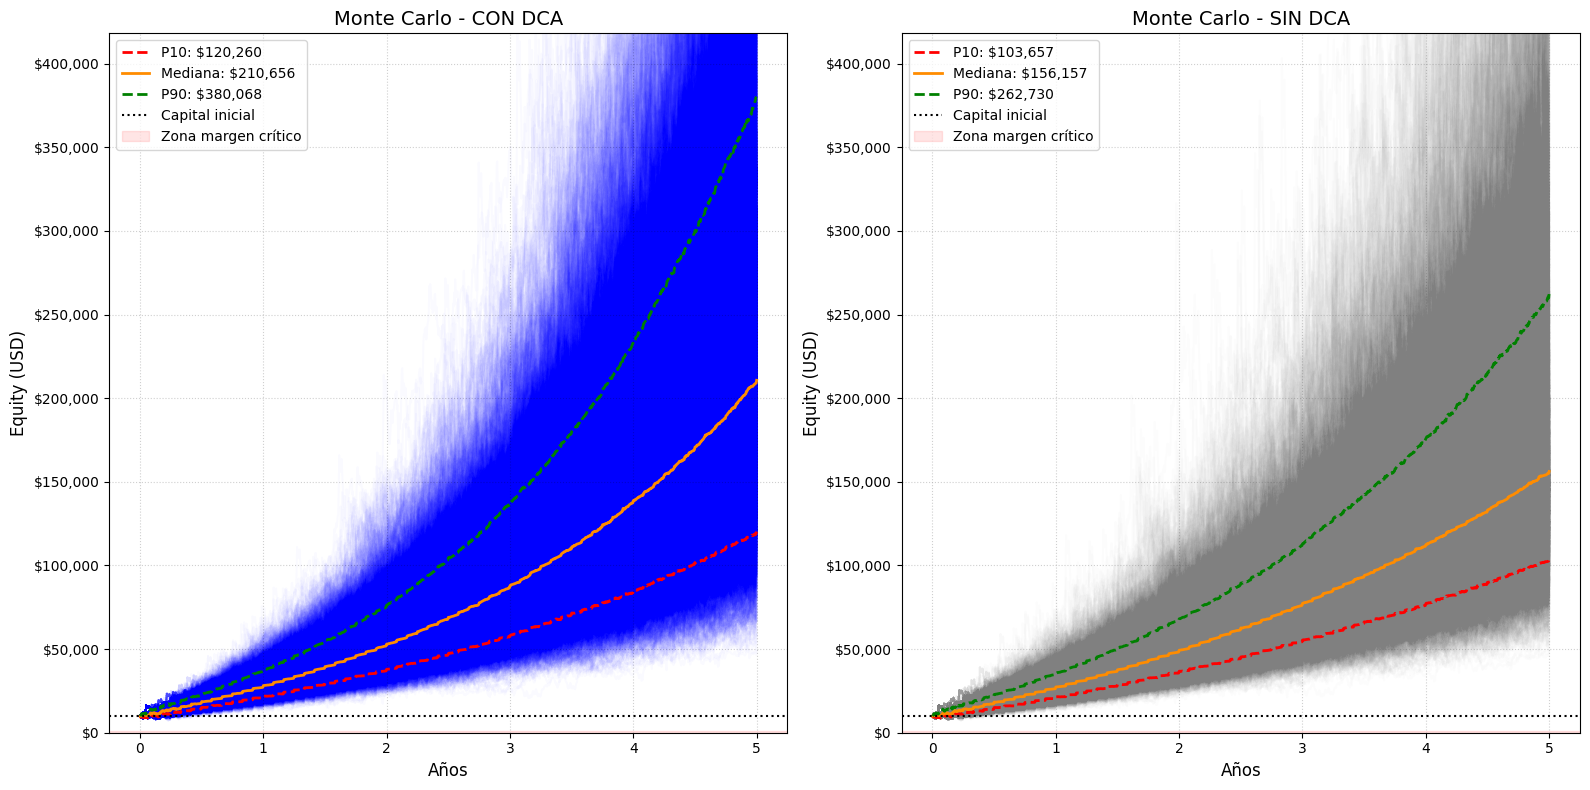

In [11]:
# Block 8: Comparison and Visualization of Results

# ==============================================================================
# COMPARISON TABLE: DCA vs SIN DCA
# ==============================================================================

print("\n" + "=" * 80)
print("             📊 COMPARACIÓN: CON DCA vs SIN DCA 📉")
print("=" * 80)

# Helper function to calculate metrics for a specific percentile trajectory
def calculate_percentile_metrics(results_dict, percentile_name):
    """Calculate metrics (Sharpe, Drawdown, IRR) for a specific percentile."""
    risk_free_rate = 0.02
    
    if percentile_name == 'P10':
        idx = results_dict['idx_p10_sharpe']
    elif percentile_name == 'P50':
        idx = results_dict['idx_p50_sharpe']
    elif percentile_name == 'P90':
        idx = results_dict['idx_p90_sharpe']
    else:
        return None, None, None
    
    trajectory = results_dict['all_results'][:, idx]
    
    # Calculate Sharpe
    sharpe = calculate_sharpe_individual(trajectory, risk_free_rate, yearly_trading_days)
    
    # Calculate Max Drawdown
    max_dd = calculate_max_drawdown(trajectory)
    
    # Calculate IRR (reconstruct cash flows from monthly contributions)
    years = METAPARAMETERS["simulation_years"]
    monthly_contrib = METAPARAMETERS["monthly_contribution"]
    initial_capital = METAPARAMETERS["initial_capital"]
    
    # Reconstruct cash flows: initial investment (negative) + monthly contributions (negative) + final value (positive)
    cash_flows = [-initial_capital]
    for month in range(1, years * 12 + 1):
        cash_flows.append(-monthly_contrib)
    cash_flows.append(trajectory[-1])  # Final value
    
    irr = calculate_annualized_irr(cash_flows)
    
    return sharpe, max_dd, irr

comparison_metrics = []
# Basic metrics
for metric_name, value_with, value_without in [
    ("Prob. Margin Call (1 año)", results_with_dca['prob_margin_call_1y'], results_without_dca['prob_margin_call_1y']),
    ("Prob. Margin Call (5 años)", results_with_dca['prob_margin_call_5y'], results_without_dca['prob_margin_call_5y']),
    ("Prob. Pérdida", results_with_dca['prob_loss'], results_without_dca['prob_loss']),
    ("Capital Final P10", results_with_dca['p10'][-1], results_without_dca['p10'][-1]),
    ("Capital Final P50", results_with_dca['p50'][-1], results_without_dca['p50'][-1]),
    ("Capital Final P90", results_with_dca['p90'][-1], results_without_dca['p90'][-1]),
]:
    diff = value_with - value_without
    diff_pct = (diff / value_without * 100) if value_without != 0 else 0.0
    
    # Determine if metric is percentage or currency based on metric name
    is_percentage = "Prob." in metric_name
    
    if is_percentage:
        # Format as percentage
        value_with_str = f"{value_with:.2f}%"
        value_without_str = f"{value_without:.2f}%"
        diff_str = f"{diff:+.2f}%"
    else:
        # Format as currency
        value_with_str = f"${value_with:,.0f}"
        value_without_str = f"${value_without:,.0f}"
        # Format difference with sign before dollar sign
        if diff >= 0:
            diff_str = f"+${diff:,.0f}"
        else:
            diff_str = f"-${abs(diff):,.0f}"
    
    comparison_metrics.append({
        'Métrica': metric_name,
        'CON DCA': value_with_str,
        'SIN DCA': value_without_str,
        'Diferencia': diff_str,
        'Diferencia %': f"{diff_pct:+.2f}%"
    })

# Calculate additional metrics for P10, P50, P90
for percentile in ['P10', 'P50', 'P90']:
    sharpe_with, max_dd_with, irr_with = calculate_percentile_metrics(results_with_dca, percentile)
    sharpe_without, max_dd_without, irr_without = calculate_percentile_metrics(results_without_dca, percentile)
    
    # Sharpe Ratio
    if sharpe_with is not None and sharpe_without is not None:
        diff_sharpe = sharpe_with - sharpe_without
        diff_pct_sharpe = (diff_sharpe / sharpe_without * 100) if sharpe_without != 0 else 0.0
        
        sharpe_with_str = f"{sharpe_with:.2f}"
        sharpe_without_str = f"{sharpe_without:.2f}"
        if diff_sharpe >= 0:
            diff_sharpe_str = f"+{diff_sharpe:.2f}"
        else:
            diff_sharpe_str = f"{diff_sharpe:.2f}"
        
        comparison_metrics.append({
            'Métrica': f'Sharpe Ratio ({percentile})',
            'CON DCA': sharpe_with_str,
            'SIN DCA': sharpe_without_str,
            'Diferencia': diff_sharpe_str,
            'Diferencia %': f"{diff_pct_sharpe:+.2f}%"
        })
    
    # Max Drawdown
    if max_dd_with is not None and max_dd_without is not None:
        diff_dd = max_dd_with - max_dd_without
        diff_pct_dd = (diff_dd / abs(max_dd_without) * 100) if max_dd_without != 0 else 0.0
        
        max_dd_with_str = f"{max_dd_with:.2f}%"
        max_dd_without_str = f"{max_dd_without:.2f}%"
        diff_dd_str = f"{diff_dd:+.2f}%"
        
        comparison_metrics.append({
            'Métrica': f'Max Drawdown ({percentile})',
            'CON DCA': max_dd_with_str,
            'SIN DCA': max_dd_without_str,
            'Diferencia': diff_dd_str,
            'Diferencia %': f"{diff_pct_dd:+.2f}%"
        })
    
    # IRR
    if irr_with is not None and not np.isnan(irr_with) and irr_without is not None and not np.isnan(irr_without):
        diff_irr = irr_with - irr_without
        diff_pct_irr = (diff_irr / abs(irr_without) * 100) if irr_without != 0 else 0.0
        
        irr_with_str = f"{irr_with * 100:.2f}%"
        irr_without_str = f"{irr_without * 100:.2f}%"
        diff_irr_str = f"{diff_irr * 100:+.2f}%"
        
        comparison_metrics.append({
            'Métrica': f'IRR Anualizado ({percentile})',
            'CON DCA': irr_with_str,
            'SIN DCA': irr_without_str,
            'Diferencia': diff_irr_str,
            'Diferencia %': f"{diff_pct_irr:+.2f}%"
        })

comparison_df = pd.DataFrame(comparison_metrics)
print(comparison_df.to_markdown(index=False))
print("=" * 80)

# ==============================================================================
# MONTHLY REBALANCING TABLES: DCA vs SIN DCA (P50 Scenario)
# ==============================================================================

def print_monthly_rebalancing_table(results_dict, label):
    """Print monthly rebalancing table showing where $2000 monthly deposit goes."""
    if not results_dict['enable_dca']:
        print(f"\n--- Rebalanceo Mensual ({label}) ---")
        print("En esta simulación SIN DCA, el depósito mensual de $2,000 se mantiene como buffer.\n")
        
        # Use actual simulation data if available
        if results_dict['idx_p50_sharpe'] in results_dict['monthly_distributions_all']:
            monthly_data = results_dict['monthly_distributions_all'][results_dict['idx_p50_sharpe']]
            asset_names = list(PORTFOLIO_OPTIMIZED.keys())
            
            distribution_rows = []
            for month_data in monthly_data:
                month = month_data['month']
                row = {'Month': month}
                
                # Show distribution to each asset (all zeros in SIN DCA)
                for asset in asset_names:
                    row[asset] = "$0.00"
                
                # Show equity deployed (always 0 in SIN DCA)
                row['Equity Deployed'] = "$0.00"
                
                # Show buffer
                row['Margin Buffer'] = f"${month_data['margin_buffer']:,.2f}"
                
                # Calculate and show borrowed amount
                capital = month_data.get('capital', 0.0)
                exposure = month_data.get('exposure', 0.0)
                borrowed = exposure - capital if exposure > capital else 0.0
                row['Borrowed'] = f"${borrowed:,.2f}"
                
                # Show total monthly contribution
                total_monthly = month_data['margin_buffer']
                row['Total Deposit'] = f"${total_monthly:,.2f}"
                
                distribution_rows.append(row)
            
            # Ensure consistent column order
            column_order = ['Month'] + asset_names + ['Equity Deployed', 'Margin Buffer', 'Borrowed', 'Total Deposit']
            rebal_df = pd.DataFrame(distribution_rows)
            rebal_df = rebal_df[column_order]
            print(rebal_df.to_markdown(index=False))
            
            # Show totals
            print("\n--- Totales Acumulados ---")
            total_buffer = sum(md['margin_buffer'] for md in monthly_data)
            
            # Get final values from last month
            final_month_data = monthly_data[-1] if monthly_data else {}
            final_capital = final_month_data.get('capital', 0.0)
            final_exposure = final_month_data.get('exposure', 0.0)
            final_borrowed = final_exposure - final_capital if final_exposure > final_capital else 0.0
            
            summary_rows = [
                {'Concepto': 'Total Depositado', 'Monto': total_buffer},
                {'Concepto': 'Margin Buffer', 'Monto': total_buffer},
                {'Concepto': 'Capital Final (Equity)', 'Monto': final_capital},
                {'Concepto': 'Exposure Final', 'Monto': final_exposure},
                {'Concepto': 'Borrowed Final', 'Monto': final_borrowed}
            ]
            
            summary_df = pd.DataFrame(summary_rows)
            summary_df['Monto'] = summary_df['Monto'].apply(lambda x: f"${x:,.2f}")
            print(summary_df.to_markdown(index=False))
            return
        
        # Fallback: theoretical calculation (should not reach here if data is available)
        monthly_contrib = METAPARAMETERS["monthly_contribution"]
        asset_names = list(PORTFOLIO_OPTIMIZED.keys())
        years = METAPARAMETERS["simulation_years"]
        
        distribution_rows = []
        for month in range(1, years * 12 + 1):
            row = {'Month': f"Año {((month - 1) // 12) + 1}, Mes {((month - 1) % 12) + 1}"}
            total_deployed = 0
            for asset in asset_names:
                amount = monthly_contrib * PORTFOLIO_OPTIMIZED[asset]
                row[asset] = f"${amount:,.2f}"
                total_deployed += amount
            row['Total Deployed'] = f"${total_deployed:,.2f}"
            row['Buffer'] = f"${monthly_contrib - total_deployed:,.2f}"
            distribution_rows.append(row)
        
        rebal_df = pd.DataFrame(distribution_rows)
        print(rebal_df.to_markdown(index=False))
        return
    
    # CON DCA: Show actual distribution from simulation
    if results_dict['idx_p50_sharpe'] in results_dict['monthly_distributions_all']:
        print(f"\n--- Rebalanceo Mensual ({label}) - Escenario Mediana (P50) ---")
        print(f"Muestra dónde se destinó el depósito mensual de ${METAPARAMETERS['monthly_contribution']} en cada mes.\n")
        
        monthly_data = results_dict['monthly_distributions_all'][results_dict['idx_p50_sharpe']]
        asset_names = list(PORTFOLIO_OPTIMIZED.keys())
        
        distribution_rows = []
        for month_data in monthly_data:
            month = month_data['month']
            row = {'Month': month}
            
            # Show distribution to each asset
            total_asset_deploy = 0
            for asset in asset_names:
                amount = month_data['distribution'].get(asset, 0.0)
                row[asset] = f"${amount:,.2f}"
                total_asset_deploy += amount
            
            # Show equity deployed (including leverage)
            row['Equity Deployed'] = f"${month_data['capital_added_to_positions']:,.2f}"
            
            # Show buffer
            row['Margin Buffer'] = f"${month_data['margin_buffer']:,.2f}"
            
            # Calculate and show borrowed amount
            capital = month_data.get('capital', 0.0)
            exposure = month_data.get('exposure', 0.0)
            borrowed = exposure - capital if exposure > capital else 0.0
            row['Borrowed'] = f"${borrowed:,.2f}"
            
            # Show total monthly contribution (should be ~$1000)
            total_monthly = month_data['capital_added_to_positions'] + month_data['margin_buffer']
            row['Total Deposit'] = f"${total_monthly:,.2f}"
            
            distribution_rows.append(row)
        
        # Ensure consistent column order
        column_order = ['Month'] + asset_names + ['Equity Deployed', 'Margin Buffer', 'Borrowed', 'Total Deposit']
        rebal_df = pd.DataFrame(distribution_rows)
        rebal_df = rebal_df[column_order]
        print(rebal_df.to_markdown(index=False))
        
        # Show totals
        print("\n--- Totales Acumulados ---")
        total_deployed = sum(md['capital_added_to_positions'] for md in monthly_data)
        total_buffer = sum(md['margin_buffer'] for md in monthly_data)
        total_contrib = total_deployed + total_buffer
        
        # Get final values from last month
        final_month_data = monthly_data[-1] if monthly_data else {}
        final_capital = final_month_data.get('capital', 0.0)
        final_exposure = final_month_data.get('exposure', 0.0)
        final_borrowed = final_exposure - final_capital if final_exposure > final_capital else 0.0
        
        cumulative_totals = {}
        for asset in asset_names:
            cumulative_totals[asset] = sum(md['distribution'].get(asset, 0.0) for md in monthly_data)
        
        summary_rows = [
            {'Concepto': 'Total Depositado', 'Monto': total_contrib},
            {'Concepto': 'Equity Deployed', 'Monto': total_deployed},
            {'Concepto': 'Margin Buffer', 'Monto': total_buffer},
            {'Concepto': 'Capital Final (Equity)', 'Monto': final_capital},
            {'Concepto': 'Exposure Final', 'Monto': final_exposure},
            {'Concepto': 'Borrowed Final', 'Monto': final_borrowed}
        ]
        
        for asset in asset_names:
            summary_rows.append({'Concepto': f"Deploy {asset}", 'Monto': cumulative_totals[asset]})
        
        summary_df = pd.DataFrame(summary_rows)
        summary_df['Monto'] = summary_df['Monto'].apply(lambda x: f"${x:,.2f}")
        print(summary_df.to_markdown(index=False))

# Print monthly rebalancing tables for both simulations
print_monthly_rebalancing_table(results_with_dca, "CON DCA")
print_monthly_rebalancing_table(results_without_dca, "SIN DCA")

print("=" * 80)

# ==============================================================================
# VISUALIZATION: Both Simulations Side by Side
# ==============================================================================

initial_capital = METAPARAMETERS["initial_capital"]
currency_formatter = FuncFormatter(lambda value, _: f'${value:,.0f}')

# Calculate Y-axis limit: 110% of CON DCA P90 final value
p90_final_value = results_with_dca['p90'][-1]
y_max = p90_final_value * 1.1

# Combined plot showing both simulations
plt.figure(figsize=(16, 8))

# CON DCA trajectories
plt.subplot(1, 2, 1)
plt.plot(results_with_dca['time_points'], results_with_dca['all_results'], color='blue', alpha=0.02)
plt.plot(results_with_dca['time_points'], results_with_dca['p10'], label=f'P10: ${results_with_dca["p10"][-1]:,.0f}', color='red', linewidth=2, linestyle='--')
plt.plot(results_with_dca['time_points'], results_with_dca['p50'], label=f'Mediana: ${results_with_dca["p50"][-1]:,.0f}', color='darkorange', linewidth=2)
plt.plot(results_with_dca['time_points'], results_with_dca['p90'], label=f'P90: ${results_with_dca["p90"][-1]:,.0f}', color='green', linewidth=2, linestyle='--')
plt.axhline(initial_capital, color='black', linestyle=':', label='Capital inicial')
plt.axhspan(0, initial_capital * 0.1, color='red', alpha=0.1, label='Zona margen crítico')
plt.title('Monte Carlo - CON DCA', fontsize=14)
plt.xlabel('Años', fontsize=12)
plt.ylabel('Equity (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(currency_formatter)
plt.ylim(0, y_max)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

# SIN DCA trajectories
plt.subplot(1, 2, 2)
plt.plot(results_without_dca['time_points'], results_without_dca['all_results'], color='grey', alpha=0.02)
plt.plot(results_without_dca['time_points'], results_without_dca['p10'], label=f'P10: ${results_without_dca["p10"][-1]:,.0f}', color='red', linewidth=2, linestyle='--')
plt.plot(results_without_dca['time_points'], results_without_dca['p50'], label=f'Mediana: ${results_without_dca["p50"][-1]:,.0f}', color='darkorange', linewidth=2)
plt.plot(results_without_dca['time_points'], results_without_dca['p90'], label=f'P90: ${results_without_dca["p90"][-1]:,.0f}', color='green', linewidth=2, linestyle='--')
plt.axhline(initial_capital, color='black', linestyle=':', label='Capital inicial')
plt.axhspan(0, initial_capital * 0.1, color='red', alpha=0.1, label='Zona margen crítico')
plt.title('Monte Carlo - SIN DCA', fontsize=14)
plt.xlabel('Años', fontsize=12)
plt.ylabel('Equity (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(currency_formatter)
plt.ylim(0, y_max)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()